## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [2]:
pip install tensorflow==2.12.0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


**QUESTION:** Load dataset and display some lines of the csv file.

In [4]:
#mounting of Google Drive:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/embedded/data/ai4i2020.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

Machine failure
0    9661
1     339
Name: count, dtype: int64


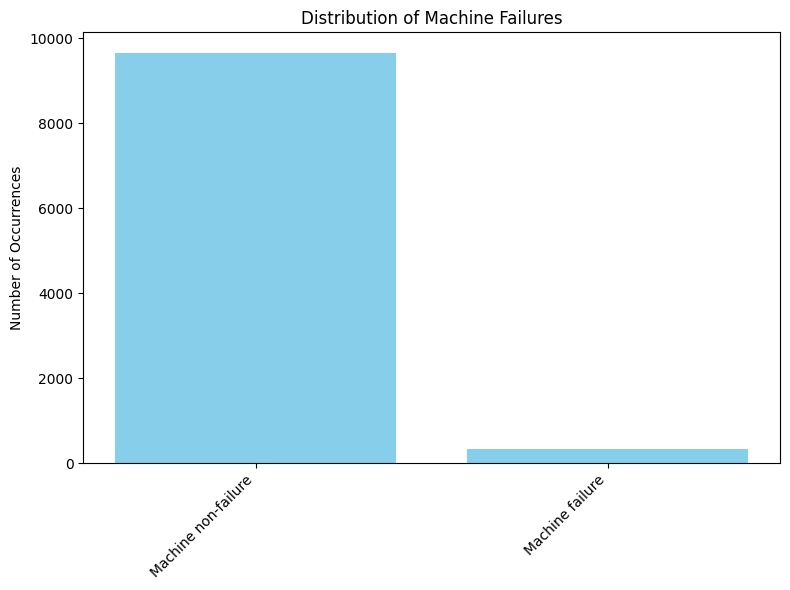

In [5]:
#count the occurrences of each failure type
failure_counts = data['Machine failure'].value_counts()
print(failure_counts) #1 = broken machine
lab = ['Machine non-failure', 'Machine failure']

#plot graph
plt.figure(figsize=(8, 6))
plt.bar(lab, failure_counts.values, color = "skyblue")
plt.xlabel("")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Machine Failures")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**ANALYSIS QUESTION:** What do you observe?

we can observe that the dataset is highly imbalanced, with failures making up only ~3.5% of the total data.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

This could lead to a bias in machine learning models, where they might predict "no failure" most of the time and still achieve high accuracy but fail to detect real failures.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

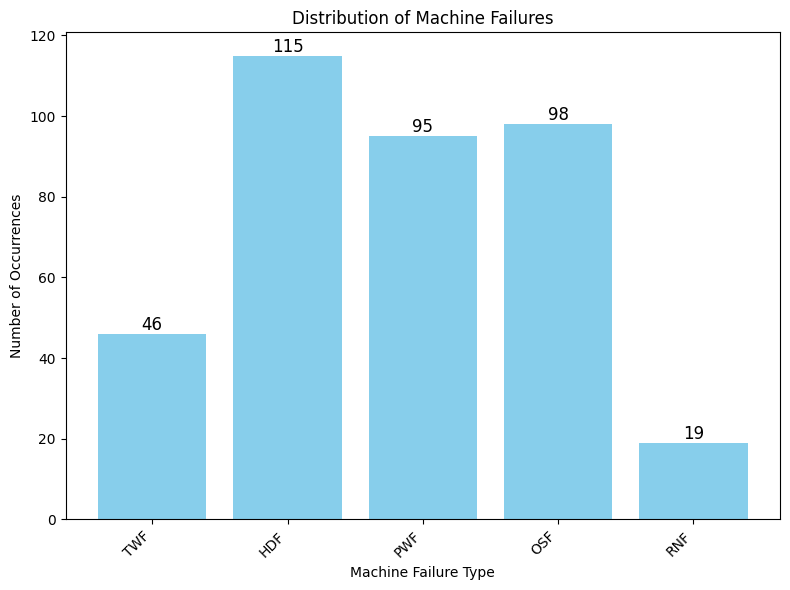

In [6]:
#failure types list
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

#occurrences of each failure type
failure_counts = data[failure_types].sum()

#plot graph
plt.figure(figsize=(8, 6))
bars = plt.bar(failure_types, failure_counts.values, color = 'skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=12)

plt.xlabel("Machine Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Machine Failures")
plt.xticks(rotation=45, ha="right")  #rotate x (lisibility)
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Among the failure types, HDF, PWF and OSF are predominants. Hence, we can expect those failures to be predicted more frequently than the others, by the model.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

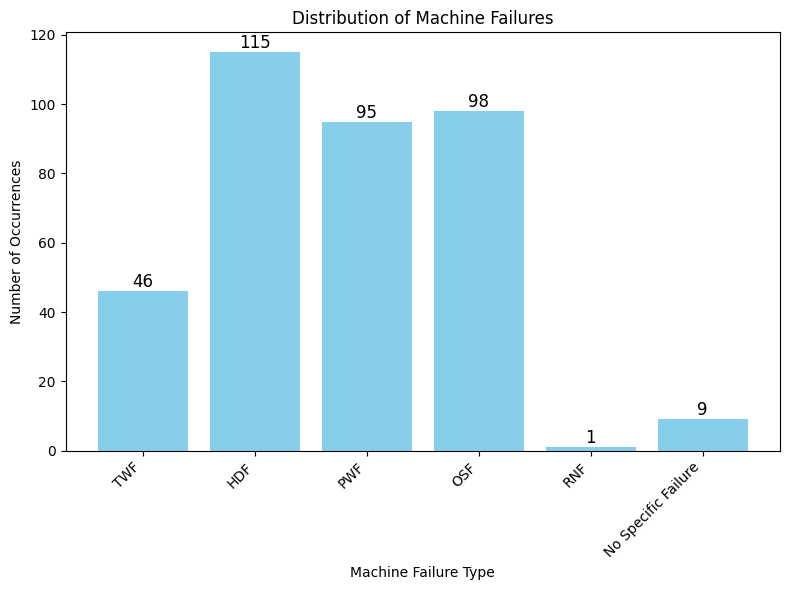

In [7]:
#machines that experienced a failure
failed_machines = data[data['Machine failure'] == 1]
failure_counts = failed_machines[failure_types].sum()

#cases where no specific failure type is recorded
no_specific_failure_count = (failed_machines[failure_types].sum(axis=1) == 0).sum()

#"No Specific Failure" category
failure_counts['No Specific Failure'] = no_specific_failure_count

#chart
plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.index, failure_counts.values, color='skyblue')

#display exact values on ech bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=12)

# Labels and title
plt.xlabel("Machine Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Machine Failures")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Compared to the previous question, we can notice that 9 machines faced a failure with no specific explanation behind. It represents 3% of the total amount of failures. Thus, our model will have at least a 3% margin error. Moreover, we seem to have lost 10 failure occurences (the previous chart reported 19 random RNF failures ). So, when the failure is random (RNF), the Machine Failure feature is not set to 1 systematically.


Fortunately the machine failure RNF occurs in only 1 observation and it has a random nature therefore not predictable so we could decide to remove these rows in the future model.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [8]:
print(data.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

To predict whether a machine will fail and determine the type of failure, we must choose features that influence failures. The most relevant input features (so our Xs) are:

- `Air temperature [K]`
- `Process temperature [K]`
- `Rotational speed [rpm]`
- `Torque [Nm]`
- `Tool wear [min]`

Of course, we exclude columns like `Product ID` that is nowhere near relevant for our training, since it is unrealistic to think that the failure of a machine depends on its identifier.

`UDI` is a copy of the dataframe index, we can also get rid of it. The column `Product ID` is made up of an initial letter followed by five numbers, that could mean something. However, the initial letter in the `Product ID` represents the machine Type, while the number sequences are divided into three intervals based on the same feature which confirms that the Product ID column does not provide additional info. We can remove it.


As for our outputs, we expect to receive one of the 5 failure causes (our labels).

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [9]:
#input features and outputs
input_features = ['Air temperature [K]', 'Process temperature [K]',
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

output_labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

#features and labels
X = data[input_features].values
Y = data[output_labels].values

#split into training and test sets (we arbitrary choose 80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#print
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (8000, 5)
Y_train shape: (8000, 6)
X_test shape: (2000, 5)
Y_test shape: (2000, 6)


**QUESTION** Code below the model architecture

Here, we define a simple MLP model with relu activation and sigmoid output for binary classification.

In [10]:
#model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  #hidden layer
    Dropout(0.2),  #dropout
    Dense(32, activation='relu'),  #hidden layer
    #Dense(50, activation='relu'),  #hidden layer
    Dense(Y_train.shape[1], activation='sigmoid')  #output layer
])

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2,662
Trainable params: 2,662
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/20
250/250 [==============================] - 3s 5ms/step - loss: 2.9946 - accuracy: 0.3735 - val_loss: 0.8305 - val_accuracy: 0.8420
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 0.9084 - accuracy: 0.4478 - val_loss: 0.4904 - val_accuracy: 0.4750
Epoch 3/20
250/250 [==============================] - 1s 5ms/step - loss: 0.5353 - accuracy: 0.5360 - val_loss: 0.2769 - val_accuracy: 0.9970
Epoch 4/20
250/250 [==============================] - 1s 6ms/step - loss: 0.3360 - accuracy: 0.6560 - val_loss: 0.2116 - val_accuracy: 0.9970
Epoch 5/20
250/250 [==============================] - 2s 8ms/step - loss: 0.2291 - accuracy: 0.7585 - val_loss: 0.1453 - val_accuracy: 0.8705
Epoch 6/20
250/250 [==============================] - 2s 9ms/step - loss: 0.1527 - accuracy: 0.7928 - val_loss: 0.1165 - val_accuracy: 0.8355
Epoch 7/20
250/250 [==============================] - 1s 5ms/step - loss: 0.1229 - accuracy: 0.7699 - val_loss: 0.0872 - val_accuracy: 0.9970
Epoch 

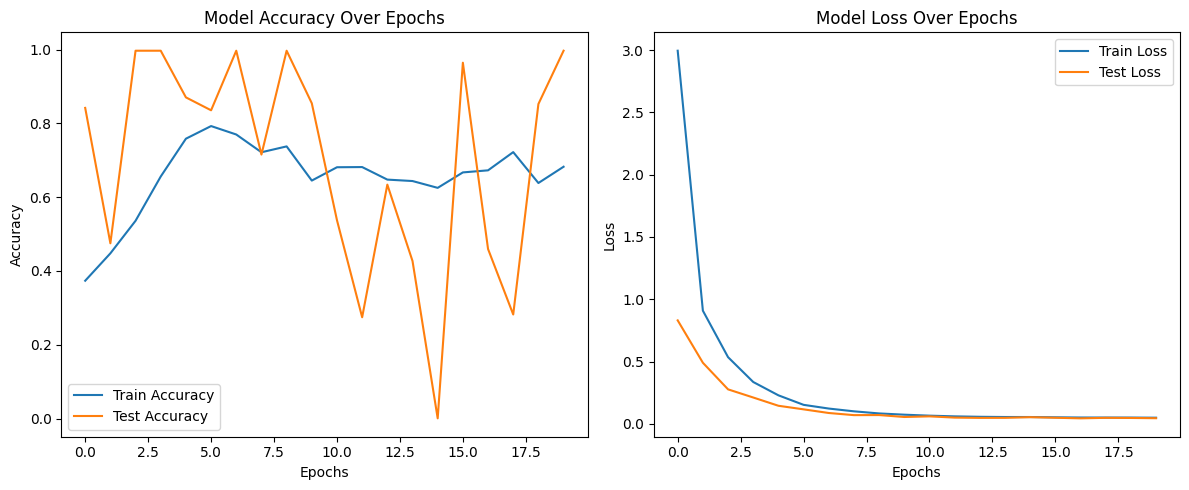

In [11]:
#training of the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

#plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()

#plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()

#ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = model.evaluate(X_train, Y_train, batch_size=32)
loss_test, acc_test = model.evaluate(X_test, Y_test, batch_size=32)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





Here, we got a problem of multi-label classification. We can either create a confusion matrix and classification report for each class or a single matrix and classification for all six classes. We chose the latter.

> **_note:_**   (a good tutorial that helped us understand : https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea/)


63/63 [==============================] - 0s 1ms/step


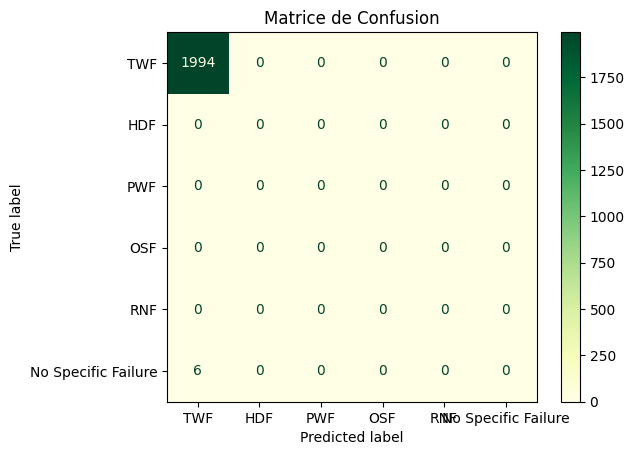

                     precision    recall  f1-score   support

                TWF       1.00      1.00      1.00      1994
                HDF       0.00      0.00      0.00         0
                PWF       0.00      0.00      0.00         0
                OSF       0.00      0.00      0.00         0
                RNF       0.00      0.00      0.00         0
No Specific Failure       0.00      0.00      0.00         6

           accuracy                           1.00      2000
          macro avg       0.17      0.17      0.17      2000
       weighted avg       0.99      1.00      1.00      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#predictions
y_pred = model.predict(X_test)

#prediction to label index
y_pred_int = np.argmax(y_pred, axis=1)

# one hot to real numbers
Y_test_int = np.argmax(Y_test, axis=1)

output_labels = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'No Specific Failure']

#confusion matrix
cm = confusion_matrix(Y_test_int, y_pred_int, labels=np.arange(len(output_labels)))
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_labels)
disp.plot(cmap=plt.cm.YlGn)
plt.title("Matrice de Confusion")
plt.show()

# Affichage du rapport de classification
print(classification_report(Y_test_int, y_pred_int, target_names=output_labels, labels=np.arange(6)))


**ANALYSIS QUESTION** What do you observe? What can you conclude?

As we already knew, our model is completely biased toward predicting only the TWF class. The overall accuracy is ~99%, but this is wrong because the model simply learned to always predict TWF, which dominates the dataset (except for 6 instances of "No Specific Failure" which we can't explain ...), so it's not recognizing any of the other classes at all. All TWF were (correctly?) classified, while all other classes have only zeros, meaning they were never predicted.


Therefore, the next move will be to address our class imbalance problem.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

For some samples, there are machine failures but no specific failure type recorded due to incomplete data. To address this, we will remove the Machine failure column and focus on the 5 specific failure types (TWF, HDF, PWF, OSF, RNF) for multiclass classification.


In [13]:
#failure tupes
Y_B = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

#if no error -> create an error column
no_error_condition = (Y_B == 0).all(axis=1)
Y_B['Error Class'] = np.where(no_error_condition, 'No Error', Y_B.idxmax(axis=1))

#slip training and test
X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(X, Y_B['Error Class'], test_size=0.2, random_state=42)

#labels encoding
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train_B)
Y_test_encoded = label_encoder.transform(Y_test_B)

#SMOTE
smote = SMOTE(random_state=42)
X_train_r, Y_train_r = smote.fit_resample(X_train_B, Y_train_encoded)
print("Distribution après SMOTE :", Counter(Y_train_r), "\n")

#Undersampling
target_count = min(Counter(Y_train_r).values())
undersample_strategy = {label: target_count for label in set(Y_train_r)}

undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_over, Y_train_over = undersample.fit_resample(X_train_r, Y_train_r)

#conv to one hot (doesn't work otherwise bc of Y_train_over format)
Y_train_over = to_categorical(Y_train_over)
Y_test_B = to_categorical(Y_test_encoded)

#print
print(f"X_train_over: {X_train_over.shape}")
print(f"Y_train_over: {Y_train_over.shape}")  #should be (n, 6) if 6 classes
print(f"X_test_B: {X_test_B.shape}")
print(f"Y_test_B: {Y_test_B.shape}", "\n")
print("Distribution après undersampling :", Counter(Y_train_encoded), "\n")


Distribution après SMOTE : Counter({1: 7717, 3: 7717, 0: 7717, 5: 7717, 2: 7717, 4: 7717}) 

X_train_over: (46302, 5)
Y_train_over: (46302, 6)
X_test_B: (2000, 5)
Y_test_B: (2000, 6) 

Distribution après undersampling : Counter({1: 7717, 0: 98, 3: 73, 2: 65, 5: 35, 4: 12}) 



<ipython-input-13-8bf5f1530777>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_B['Error Class'] = np.where(no_error_condition, 'No Error', Y_B.idxmax(axis=1))


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

To address the class imbalance, we used SMOTE to generate synthetic samples for minority classes. This ensures that all classes have an equal number of samples, which will prevent the model from being biased toward the majority class. We also removed the Machine failure column to focus on specific failure types, as it was causing ambiguity in the dataset.

We also added the undersampling method that remove examples from the training dataset that belong to the majority class in order to better balance the class distribution

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [14]:
#model architecture
# model_B = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train_over.shape[1],)),  # Hidden layer
#     Dropout(0.2),  # Dropout
#     Dense(128, activation='relu'),  # Hidden layer
#     Dense(128, activation='relu'),
#     Dense(Y_train_over.shape[1], activation='sigmoid')  # Output layer
# ])

model_B = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_over.shape[1],)),  # Hidden layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout
    Dense(Y_train_over.shape[1], activation='sigmoid')  # Output layer
])

# model_B = Sequential([
#     Dense(16, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_over.shape[1],)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(Y_train_over.shape[1], activation='softmax')
# ])

# Compile the model
model_B.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                192       
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
Total params: 11,398
Trainable params: 11,398
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model


Epoch 1/20
1447/1447 [==============================] - 4s 2ms/step - loss: 0.6468 - accuracy: 0.4751 - val_loss: 0.3123 - val_accuracy: 0.6560
Epoch 2/20
1447/1447 [==============================] - 4s 3ms/step - loss: 0.2994 - accuracy: 0.5479 - val_loss: 0.3005 - val_accuracy: 0.7275
Epoch 3/20
1447/1447 [==============================] - 3s 2ms/step - loss: 0.2766 - accuracy: 0.5904 - val_loss: 0.2801 - val_accuracy: 0.6160
Epoch 4/20
1447/1447 [==============================] - 3s 2ms/step - loss: 0.2629 - accuracy: 0.6160 - val_loss: 0.2786 - val_accuracy: 0.6425
Epoch 5/20
1447/1447 [==============================] - 3s 2ms/step - loss: 0.2433 - accuracy: 0.6583 - val_loss: 0.2687 - val_accuracy: 0.6610
Epoch 6/20
1447/1447 [==============================] - 4s 3ms/step - loss: 0.2181 - accuracy: 0.7174 - val_loss: 0.3278 - val_accuracy: 0.4780
Epoch 7/20
1447/1447 [==============================] - 3s 2ms/step - loss: 0.1974 - accuracy: 0.7531 - val_loss: 0.1829 - val_accuracy:

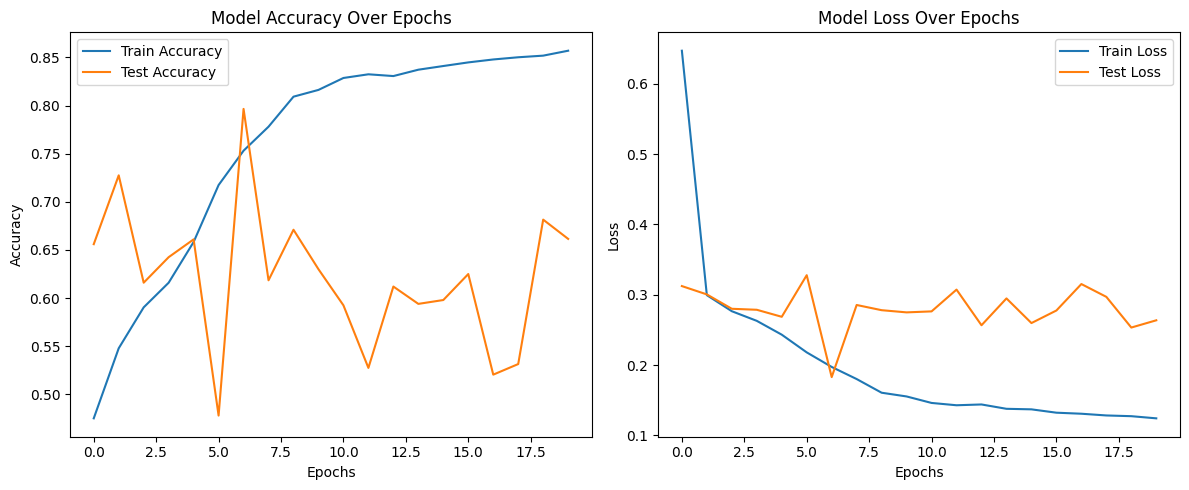

In [15]:
#training of the model
history = model_B.fit(X_train_over, Y_train_over, epochs=20, batch_size=32, validation_data=(X_test_B, Y_test_B))

#plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()

#plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()

#ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = model.evaluate(X_train, Y_train, batch_size=32)
loss_test, acc_test = model.evaluate(X_test, Y_test, batch_size=32)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

This time, we'll do a class report and a confusion matrix per class (so 6 in total) in order to better understand the implications of it.

63/63 [==============================] - 0s 1ms/step


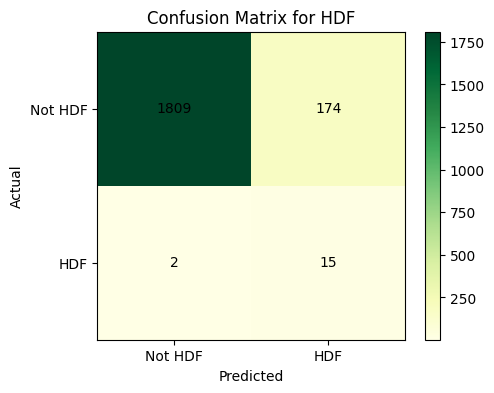

Classification Report for HDF:

              precision    recall  f1-score   support

     Not HDF       1.00      0.91      0.95      1983
         HDF       0.08      0.88      0.15        17

    accuracy                           0.91      2000
   macro avg       0.54      0.90      0.55      2000
weighted avg       0.99      0.91      0.95      2000



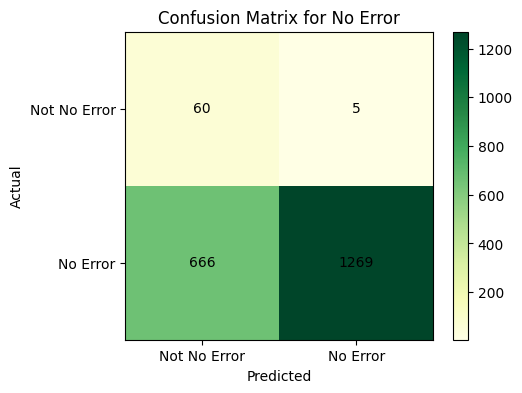

Classification Report for No Error:

              precision    recall  f1-score   support

Not No Error       0.08      0.92      0.15        65
    No Error       1.00      0.66      0.79      1935

    accuracy                           0.66      2000
   macro avg       0.54      0.79      0.47      2000
weighted avg       0.97      0.66      0.77      2000



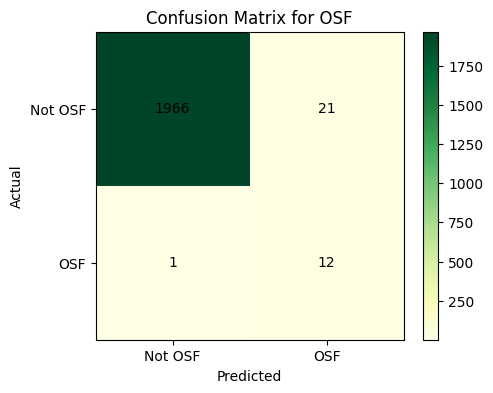

Classification Report for OSF:

              precision    recall  f1-score   support

     Not OSF       1.00      0.99      0.99      1987
         OSF       0.36      0.92      0.52        13

    accuracy                           0.99      2000
   macro avg       0.68      0.96      0.76      2000
weighted avg       1.00      0.99      0.99      2000



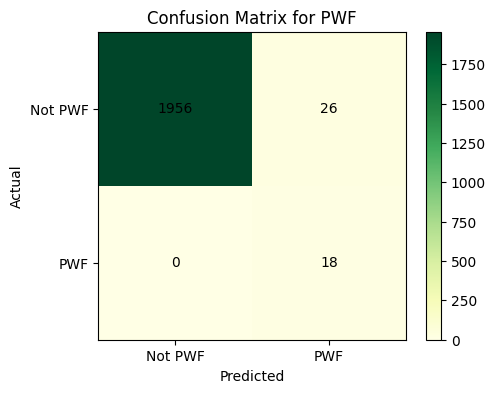

Classification Report for PWF:

              precision    recall  f1-score   support

     Not PWF       1.00      0.99      0.99      1982
         PWF       0.41      1.00      0.58        18

    accuracy                           0.99      2000
   macro avg       0.70      0.99      0.79      2000
weighted avg       0.99      0.99      0.99      2000



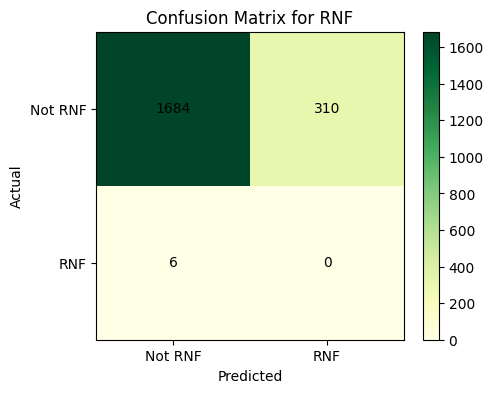

Classification Report for RNF:

              precision    recall  f1-score   support

     Not RNF       1.00      0.84      0.91      1994
         RNF       0.00      0.00      0.00         6

    accuracy                           0.84      2000
   macro avg       0.50      0.42      0.46      2000
weighted avg       0.99      0.84      0.91      2000



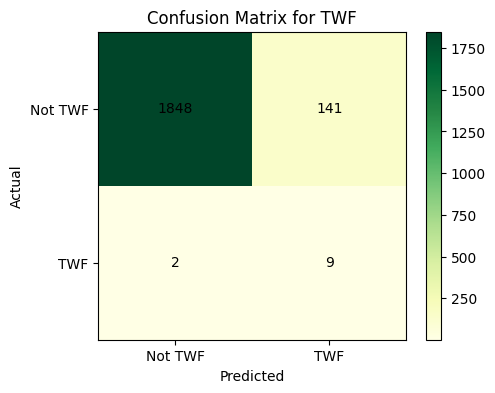

Classification Report for TWF:

              precision    recall  f1-score   support

     Not TWF       1.00      0.93      0.96      1989
         TWF       0.06      0.82      0.11        11

    accuracy                           0.93      2000
   macro avg       0.53      0.87      0.54      2000
weighted avg       0.99      0.93      0.96      2000



In [16]:
#model predictions
Y_pred_prob = model_B.predict(X_test_B)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = np.argmax(Y_test_B, axis=1)

#class labels
class_labels = label_encoder.classes_

#plot confusion matrices and classification reports per class
for i, class_name in enumerate(class_labels):
    cm = confusion_matrix(Y_true == i, Y_pred == i)
    report = classification_report(Y_true == i, Y_pred == i, target_names=["Not " + class_name, class_name])

    # Confusion matrix plot
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="YlGn", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1], ["Not " + class_name, class_name])
    plt.yticks([0, 1], ["Not " + class_name, class_name])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {class_name}")

    # Add text annotations
    for x in range(2):
        for y in range(2):
            plt.text(y, x, cm[x, y], ha="center", va="center", color="black")

    plt.show()

    # Classification report
    print(f"Classification Report for {class_name}:\n")
    print(report)
    print("=" * 60)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

### Save our model

In [18]:
np.save("X_test_pred.npy", X_test_B)
np.save("Y_test_pred.npy", Y_test_B)
model.save("pred_model.h5")